下载、观察数据集只运行一次有数据就可以了

In [ ]:
'''!mkdir DataSet
!mkdir saved_models
!wget -c "http://oss.hacking-linux.com/Dogs_vs_Cats/train.zip" -O DataSet/train.zip
!wget -c "http://oss.hacking-linux.com/Dogs_vs_Cats/test.zip" -O DataSet/test.zip
!wget -c "http://oss.hacking-linux.com/Dogs_vs_Cats/sample_submission.csv" -O DataSet/sample_submission.csv
!unzip DataSet/train.zip -d DataSet/
!unzip DataSet/test.zip -d DataSet/
'''

导入需要的库

In [2]:
import os
import re
import cv2
import csv
import h5py
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
from random import choice
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.utils import shuffle
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Lambda
from keras.layers import Input, Dropout, Flatten, Dense, BatchNormalization
from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint
from keras.applications.xception import Xception ,preprocess_input ,decode_predictions
from keras.applications.resnet50 import ResNet50 ,preprocess_input
from keras.applications import *
%matplotlib inline

建立对应的路径

In [3]:
train_filenames = os.listdir('DataSet/train')
test_filenames = os.listdir('DataSet/test')
img_size = (224,224,3)
batch_size = 16

根据规则，读入图片的同时，设定Y。  **猫：0   狗：1** 很奇怪不知道为什么进度条变成了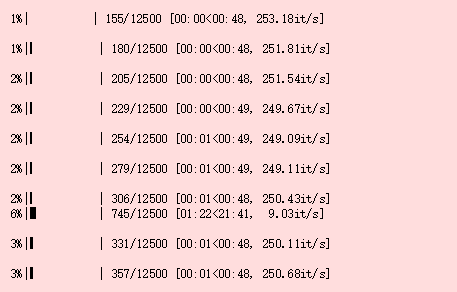

In [ ]:
np.random.seed(2017)

n = 25000
X = np.zeros((n, 224, 224, 3), dtype=np.uint8)
y = np.zeros((n, 1), dtype=np.uint8)

for i in tqdm(range(n//2)):
    X[i] = cv2.resize(cv2.imread('DataSet/train/cat.%d.jpg' % i), (224, 224))
    X[i+n//2] = cv2.resize(cv2.imread('DataSet/train/dog.%d.jpg' % i), (224, 224))

y[n//2:] = 1

首先选用一种预训练的模型并载入，得到预训练模型的权重，对图片进行预测

In [7]:
model = ResNet50(weights='imagenet')

102858752/102853048 [==============================] - 1s 0us/step


In [16]:
pre = model.predict(X)

In [17]:
a=pre[12523].argsort()[::-1]
a[:10]

array([185, 194, 192, 200, 175, 199, 186, 202, 203, 190])

In [18]:
decode_predictions(pre,top = 10)[12523]

40960/35363 [==================================] - 0s 1us/step


[('n02094114', 'Norfolk_terrier', 0.5675041),
 ('n02096437', 'Dandie_Dinmont', 0.2213604),
 ('n02096177', 'cairn', 0.07630578),
 ('n02097474', 'Tibetan_terrier', 0.042528518),
 ('n02091635', 'otterhound', 0.031057019),
 ('n02097298', 'Scotch_terrier', 0.010485479),
 ('n02094258', 'Norwich_terrier', 0.0080392035),
 ('n02098105', 'soft-coated_wheaten_terrier', 0.0066866917),
 ('n02098286', 'West_Highland_white_terrier', 0.0060296124),
 ('n02095889', 'Sealyham_terrier', 0.005331121)]

下载预训练模型对**ImageNet**的分类**Class**

In [19]:
!git clone https://github.com/kylechenoO/ImageNetClasses.git

fatal: destination path 'ImageNetClasses' already exists and is not an empty directory.


In [20]:
ImageNetClasses_fp = 'ImageNetClasses/ImageNetClasses.csv'

找出猫、狗对应的分类的**index**

In [21]:
def get_rightClass(fp):
    rightClass = []
    i = 0
    with open(fp, 'r') as r:
        reader = csv.reader(r)
        for line in reader:
            if (line[1] == '猫') or (line[1] == '狗'):
                rightClass.append(i)
            i += 1
    return(rightClass)

In [22]:
real_class = get_rightClass(ImageNetClasses_fp)
real_class = np.array(real_class)

In [23]:
real_class

array([151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163,
       164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176,
       177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189,
       190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202,
       203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215,
       216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228,
       229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241,
       242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254,
       255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267,
       268, 281, 282, 283, 284, 285, 286, 287])

将模型的预测结果和**ImageNet**的正确分类进行对比，找出**top50**的分类错误图片

In [24]:
def get_wrong_img(pred,real_class):
    wrong_img = []
    for i in range(25000):
        img_pre=pre[i].argsort()[::-1][:50]
        j = 0
        while j <50:
            if img_pre[j] in real_class:
                break
            j += 1
            if j == 50:
                wrong_img.append(i)
    return wrong_img

In [25]:
wrong_img = get_wrong_img(pre,real_class)

In [26]:
len(wrong_img)

63

**25000**找到了**63**张，输出图片查看

In [27]:
def show_img(num):
    for i in num:
        if i>=12500:
            img = Image.open('DataSet/train/dog.%d.jpg' % (i-12500))
        else:
            img = Image.open('DataSet/train/cat.%d.jpg' % i)
        plt.imshow(img)
        plt.show()

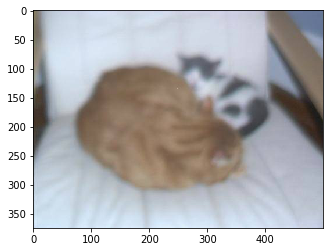

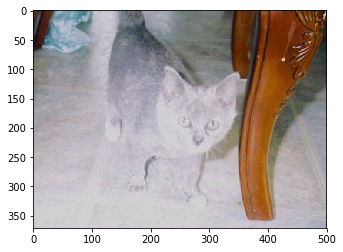

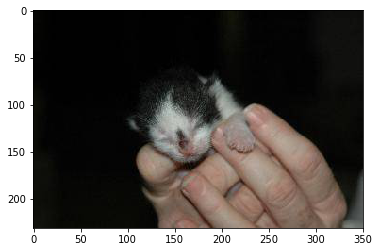

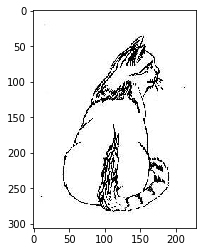

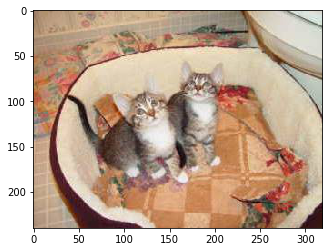

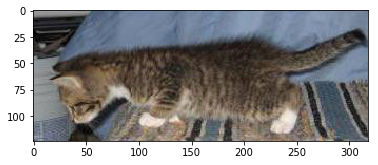

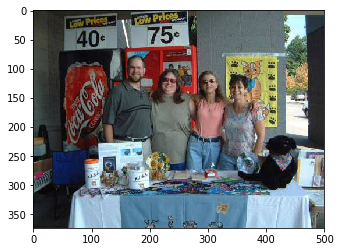

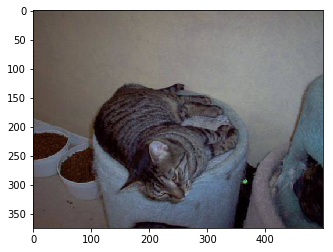

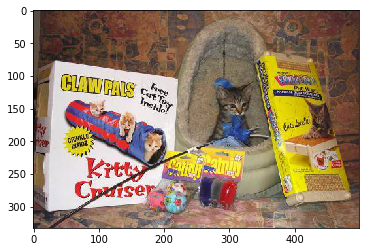

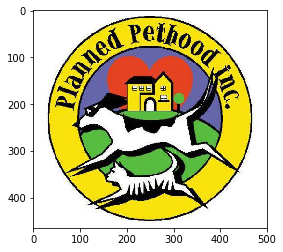

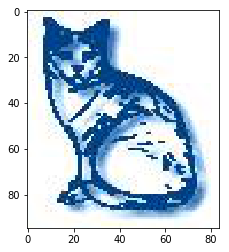

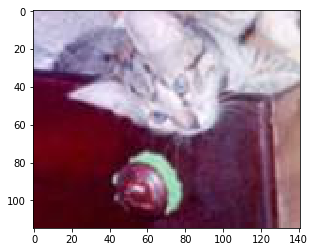

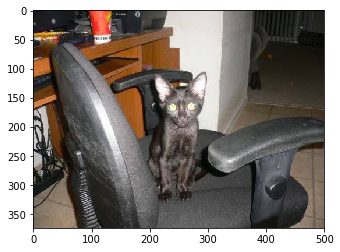

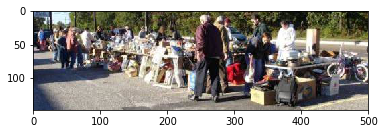

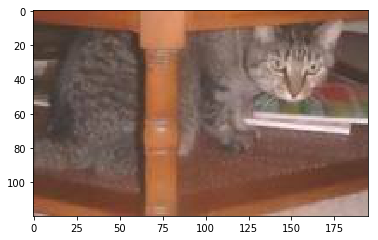

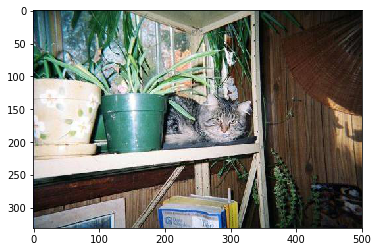

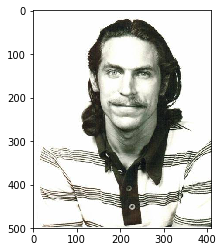

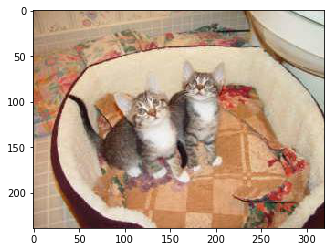

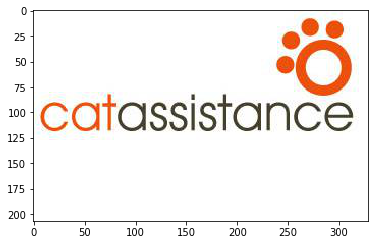

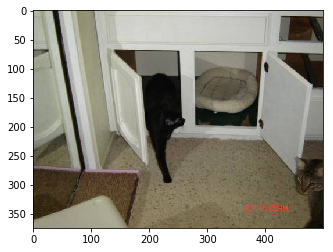

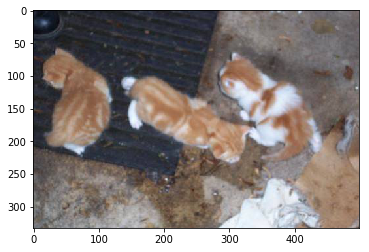

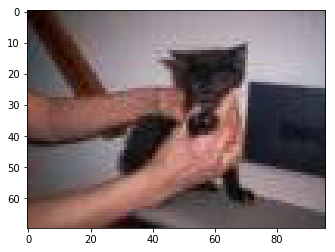

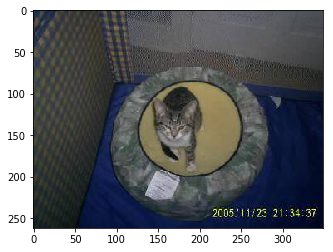

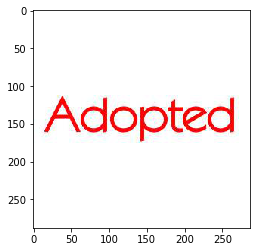

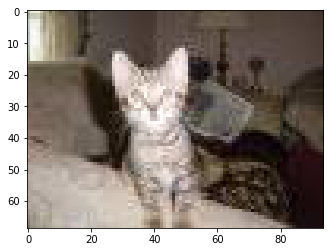

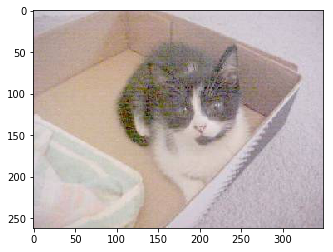

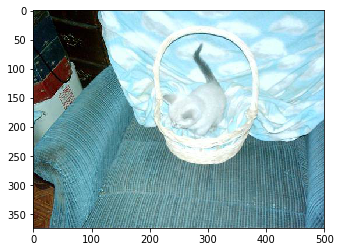

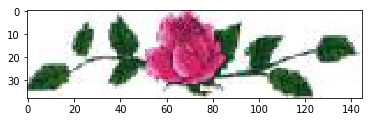

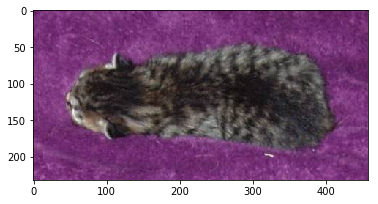

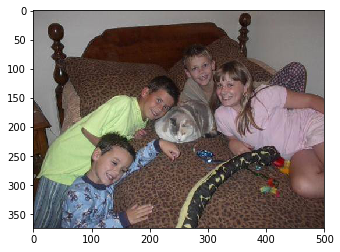

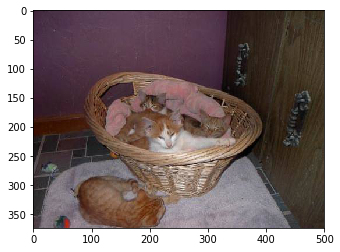

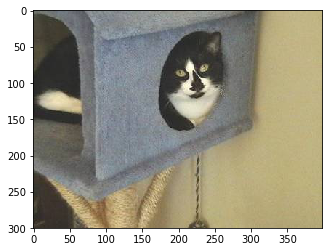

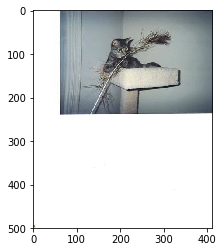

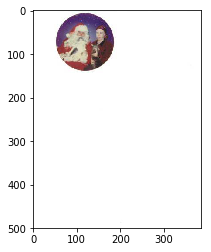

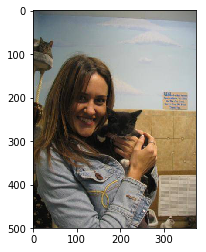

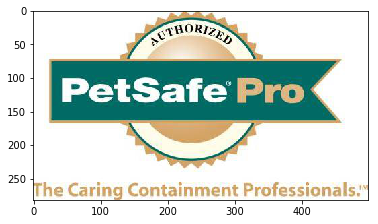

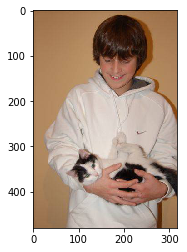

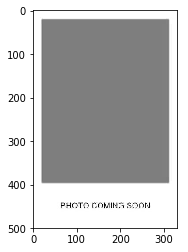

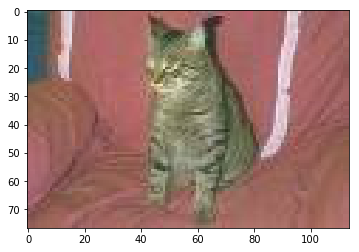

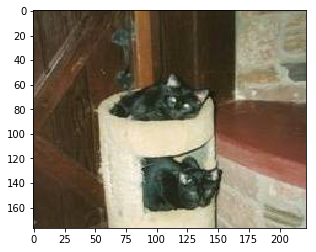

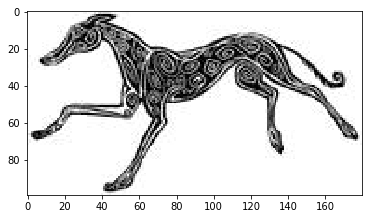

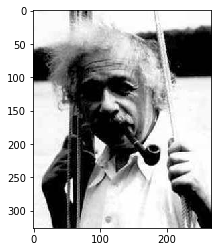

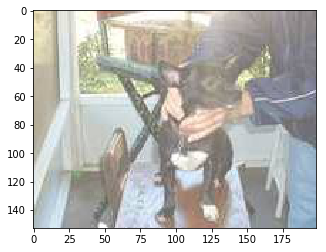

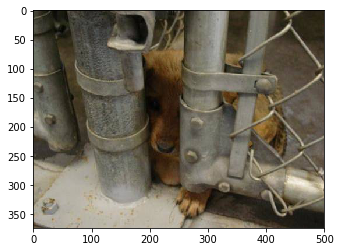

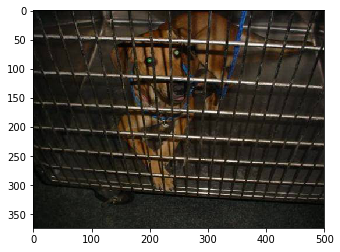

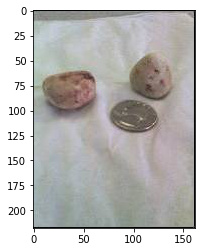

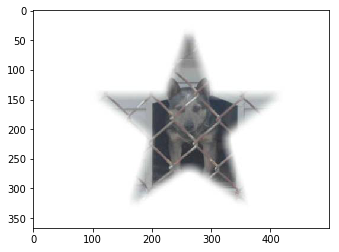

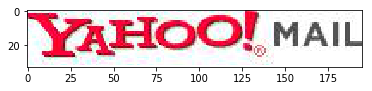

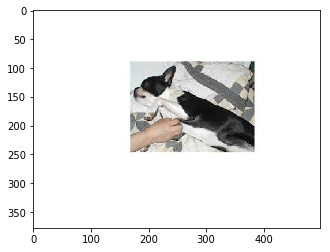

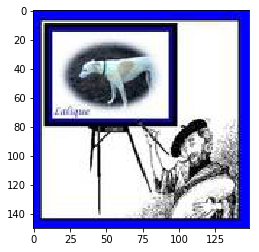

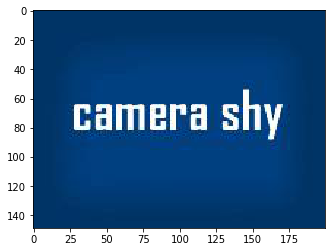

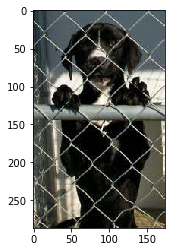

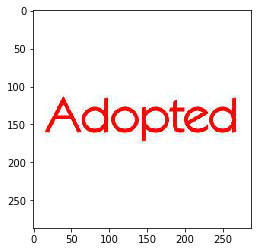

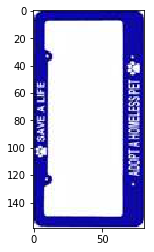

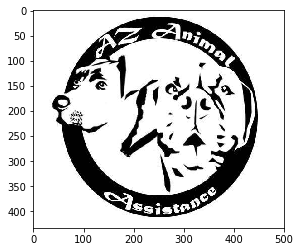

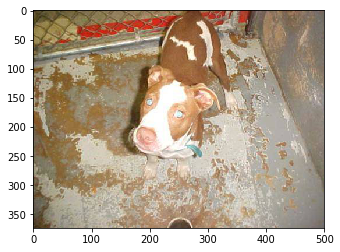

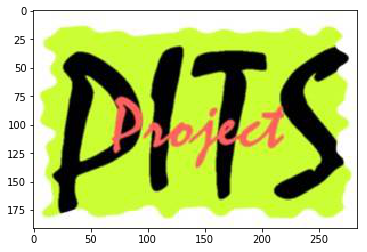

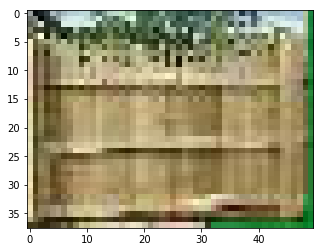

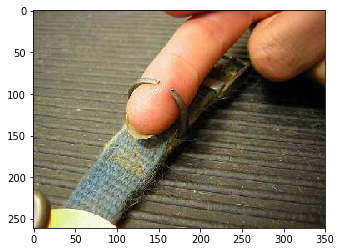

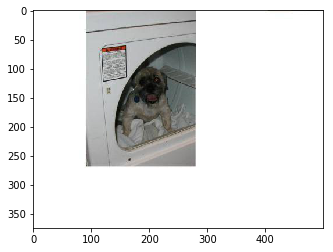

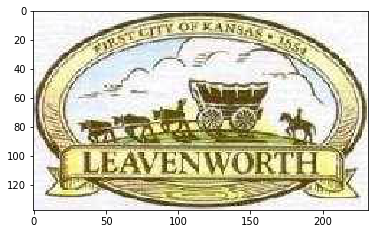

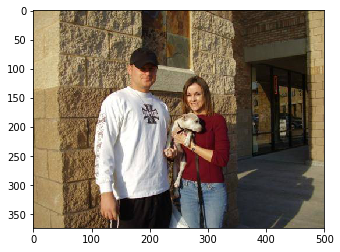

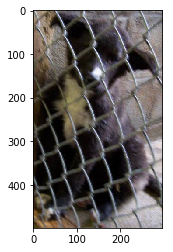

In [28]:
show_img(wrong_img)

虽然也有一些属于猫狗，但是特征基本不明显，其余的大部分很明显属于噪声，可以删除

In [29]:
def remove_wrong_img(wrong_img):
    for i in wrong_img:
        if i <12500:
            os.remove('DataSet/train/cat.%d.jpg' % i)
        else:
            os.remove('DataSet/train/dog.%d.jpg' % (i-12500))

In [30]:
remove_wrong_img(wrong_img)

In [31]:
from keras.preprocessing import image
train_filenames = os.listdir('DataSet/train')
test_filenames = os.listdir('DataSet/test')

读入图片数据为x_train和x_test，并根据猫狗命名规则，得到我们的标签

In [32]:
def get_data():
    x_train=[]
    for i in train_filenames:
        train_label = np.array([0 if i[:3]=='cat' else  1 for i in train_filenames])
        x=image.load_img('DataSet/train/'+i,target_size=(299,299))
        x=image.img_to_array(x)
        x_train.append(x)
    x_train=np.array(x_train)
    x_test=[]
    for i in test_filenames:
        x=image.load_img('DataSet/test/'+i,target_size=(299,299))
        x=image.img_to_array(x)
        x_test.append(x)
    x_test=np.array(x_test)
    print('finish')
    return x_train,train_label,x_test

In [33]:
x_train, train_label, x_test=get_data()

finish


查看x_train的shape，可以看出上面的异常图片筛选是成功了

In [34]:
x_train.shape

(24937, 299, 299, 3)

因为之前尝试了单模型的训练，结果并不理想，因此这里使用了成绩较好的两个模型进行融合训练，所以写一个函数导入模型权重并存储。

In [39]:
def write_gap(MODEL,lambda_func):
    input_tensor = Input((299, 299, 3))
    x = input_tensor
    x = Lambda(lambda_func)(x)
    
    base_model = MODEL(input_tensor=x, weights='imagenet', include_top=False)
    model = Model(base_model.input, GlobalAveragePooling2D()(base_model.output))

    gen = ImageDataGenerator()
    
    train = model.predict_generator(gen.flow(x_train, train_label,shuffle = False, batch_size = batch_size), verbose = 1)
    test = model.predict_generator(gen.flow(x_test,shuffle = False, batch_size = batch_size), verbose = 1)

    with h5py.File("gap_%s.hdf5"%MODEL) as h:
        h.create_dataset("train", data = train)
        h.create_dataset("test", data = test)
        h.create_dataset("label", data = train_label)

In [40]:
write_gap(InceptionV3,  inception_v3.preprocess_input)
write_gap(Xception, xception.preprocess_input)

782/782 [==============================] - 320s 410ms/step


In [42]:
X_train = []
X_test = []

for filename in ["gap_<function InceptionV3 at 0x7facbc5b9268>.hdf5", "gap_<function Xception at 0x7facbc5b97b8>.hdf5"]:
    with h5py.File(filename, 'r') as h:
        X_train.append(np.array(h['train']))
        X_test.append(np.array(h['test']))
        y_train = np.array(h['label'])

X_train = np.concatenate(X_train, axis=1)
X_test = np.concatenate(X_test, axis=1)

X_train, y_train = shuffle(X_train, y_train)

In [43]:
input_tensor = Input(X_train.shape[1:])
x = Dropout(0.3)(input_tensor)
x = Dense(1, activation='sigmoid')(x)
model_final = Model(input_tensor, x)

In [44]:
model_final.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])

In [45]:
batch_size = 64
model_final.fit(X_train, y_train, validation_split = 0.3,epochs = 10, batch_size = batch_size, verbose = 1)

Train on 17455 samples, validate on 7482 samples
Epoch 1/10
17455/17455 [==============================] - 7s 384us/step - loss: 0.0580 - acc: 0.9885 - val_loss: 0.0228 - val_acc: 0.9926
Epoch 2/10
17455/17455 [==============================] - 2s 87us/step - loss: 0.0166 - acc: 0.9951 - val_loss: 0.0170 - val_acc: 0.9953
Epoch 3/10
17455/17455 [==============================] - 2s 88us/step - loss: 0.0134 - acc: 0.9958 - val_loss: 0.0177 - val_acc: 0.9959
Epoch 4/10
17455/17455 [==============================] - 2s 88us/step - loss: 0.0125 - acc: 0.9960 - val_loss: 0.0162 - val_acc: 0.9953
Epoch 5/10
17455/17455 [==============================] - 2s 88us/step - loss: 0.0113 - acc: 0.9964 - val_loss: 0.0182 - val_acc: 0.9949
Epoch 6/10
17455/17455 [==============================] - 2s 88us/step - loss: 0.0106 - acc: 0.9970 - val_loss: 0.0161 - val_acc: 0.9952
Epoch 7/10
17455/17455 [==============================] - 2s 87us/step - loss: 0.0103 - acc: 0.9967 - val_loss: 0.0161 - val_acc

这里可以看出正确率已经到达了99.55%左右，属于很不错的成绩了，接下来，我们队x_test进行预测

In [46]:
y_pred = model_final.predict(X_test)

In [47]:
y_pred = y_pred.clip(min=0.005, max=0.995)

这里采用了一个打成绩的小技巧，们将每个预测值限制到了 [0.005, 0.995] 个区间内，这个原因很简单，kaggle 官方的评估标准是 LogLoss，
对于预测正确的样本，0.995 和 1 相差无几，但是对于预测错误的样本，0 和 0.005 的差距非常大，是 15 和 2 的差别。所以我们这个操作将一
定程度的提升我们的最终提交成绩

In [70]:
y_pred[:2]

array([[0.005],
       [0.005]], dtype=float32)

因为测试集的命名方式是随机打乱了的序号，所以我们尝试读入图片的名字，然后的到序号，将此序号作为Index最后把对应的y_pred输入到正确的位置。

In [60]:
y_num = [i.split('.')[0] for i in test_filenames]

In [68]:
type(y_num[0])

str

In [48]:
df = pd.read_csv("DataSet/sample_submission.csv")

In [72]:
import pandas as pd
for i in range(12500):
        df.set_value(int(y_num[i])-1, 'label', y_pred[i])
df.to_csv('pred.csv', index=None)
df.head(10)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  app.launch_new_instance()


id  label
0   1.0  0.995
1   2.0  0.995
2   3.0  0.995
3   4.0  0.995
4   5.0  0.005
5   6.0  0.005
6   7.0  0.005
7   8.0  0.005
8   9.0  0.005
9  10.0  0.005

这里最终还是有一个小错误，我们最终的**pred.csv**中的**label**不知道为什么比**ID**列多了两行，然后我很随意的删掉了最后两个预测结果，但是最终的提交成绩竟然还不错，达到了0.03888，可以排到13名，1%。所以那就先这样吧。